In [0]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

In [0]:
data_df = pd.read_excel('SmartFren Topic Classification.xlsx')

In [44]:
len(data_df)

2141

In [45]:
type(data_df['IDENTIFIED'][0])

numpy.float64

In [46]:
len(data_df[data_df['IDENTIFIED']<=0])

552

In [47]:
data_df = data_df[data_df['IDENTIFIED']>0].copy()
len(data_df)

1589

In [48]:
data_df.head()

,VERBATIMS,SPELLING CHECK,IDENTIFIED,INTERNET NETWORK,INTERNET NETWORK: speed,INTERNET NETWORK: coverage,INTERNET NETWORK: stability,INTERNET NETWORK: strength,INTERNET NETWORK: improvement,INTERNET NETWORK: inside building,MySmartfren Apps,DATA PACKAGE,DATA PACKAGE: price,DATA PACKAGE: night quota,DATA PACKAGE: top up,ONLINE GAME,DISRUPTION,4G LTE,DAILY FUP,YOUTUBE AND VIDEO STREAMING,PHONE CALL,SMS,SALDO CHECKING,ACTIVATION CES,TOP-UP CES,MYSMERTFREN CES
0,Aplikasi My Smartfren tidak sesuai dengan peng...,NaN,3.371658,1.847759,1.000000,0.000000,0.000000,0.000000,1.414214,0.0,1.414214,1.937599,1.565085,0.000000,1.189207,0.0,0,0.0,0.0,0.000000,0.0,0.0,1.0,NaN,1.0,NaN
1,"Kalau top up tidak ada masalah, tetapi pada ku...",NaN,3.198107,2.645172,1.414214,0.000000,1.414214,1.189207,1.565085,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,0,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,7.0,NaN
2,Sinyal sering hilang2 timbul truss di beberapa...,sinyal sering hilang timbul trus di beberapa d...,3.156393,2.423015,0.000000,1.681793,1.000000,1.000000,1.189207,0.0,0.000000,1.479597,1.189207,0.000000,0.000000,0.0,0,0.0,0.0,0.000000,0.0,0.0,0.0,7.0,NaN,NaN
3,"Kestabilan sinyal, karena pada jam tertentu te...",NaN,3.090583,2.217993,1.189207,1.000000,1.316074,0.000000,0.000000,0.0,0.000000,1.414214,0.000000,1.000000,0.000000,0.0,0,0.0,0.0,1.414214,0.0,0.0,0.0,NaN,7.0,NaN
4,Kekuatan sinyal di daerah tertentu seperti peg...,kekuatan sinyal di daerah tertentu seperti peg...,3.037533,2.314673,0.000000,1.189207,1.189207,1.565085,0.000000,0.0,0.000000,1.652358,0.000000,1.316074,0.000000,0.0,0,0.0,0.0,0.000000,0.0,0.0,0.0,NaN,7.0,NaN


In [49]:
data_df.columns

Index(['VERBATIMS', 'SPELLING CHECK', 'IDENTIFIED', 'INTERNET NETWORK',
       'INTERNET NETWORK: speed', 'INTERNET NETWORK: coverage',
       'INTERNET NETWORK: stability', 'INTERNET NETWORK: strength',
       'INTERNET NETWORK: improvement', 'INTERNET NETWORK: inside building',
       'MySmartfren Apps', 'DATA PACKAGE', 'DATA PACKAGE: price',
       'DATA PACKAGE: night quota', 'DATA PACKAGE: top up', 'ONLINE GAME',
       'DISRUPTION', '4G LTE', 'DAILY FUP', 'YOUTUBE AND VIDEO STREAMING',
       'PHONE CALL', 'SMS', 'SALDO CHECKING', 'ACTIVATION CES', 'TOP-UP CES',
       'MYSMERTFREN CES'],
      dtype='object')

In [0]:
del data_df['INTERNET NETWORK']
del data_df['DATA PACKAGE']
del data_df['ACTIVATION CES']
del data_df['TOP-UP CES']
del data_df['MYSMERTFREN CES']

In [0]:
def one_or_zero(value):
  if float(value) > 0:
    return 1
  else:
    return 0


In [0]:
for each_col in data_df.columns:
  if str(each_col).lower() not in [str('VERBATIMS').lower(),str('SPELLING CHECK').lower()]:
    data_df[each_col] = data_df[each_col].apply(one_or_zero)

In [53]:
print(data_df['SPELLING CHECK'][0])
print(type(data_df['SPELLING CHECK'][0]))
#need to convert nans to strings

nan
<class 'float'>


In [54]:
data_df['SPELLING CHECK'] = data_df['SPELLING CHECK'].apply(str)
print(data_df['SPELLING CHECK'][0])
print(type(data_df['SPELLING CHECK'][0]))

nan
<class 'str'>


In [0]:
def fill_spell_corrected(original, spellchecked):
  if spellchecked == 'nan':
    return original
  else:
    return spellchecked

In [56]:
data_df['TEXT_SPELL_CORRECTED'] = data_df[['VERBATIMS', 'SPELLING CHECK']].apply(lambda row: fill_spell_corrected(row['VERBATIMS'], row['SPELLING CHECK']), axis=1)
data_df.head()

,VERBATIMS,SPELLING CHECK,IDENTIFIED,INTERNET NETWORK: speed,INTERNET NETWORK: coverage,INTERNET NETWORK: stability,INTERNET NETWORK: strength,INTERNET NETWORK: improvement,INTERNET NETWORK: inside building,MySmartfren Apps,DATA PACKAGE: price,DATA PACKAGE: night quota,DATA PACKAGE: top up,ONLINE GAME,DISRUPTION,4G LTE,DAILY FUP,YOUTUBE AND VIDEO STREAMING,PHONE CALL,SMS,SALDO CHECKING,TEXT_SPELL_CORRECTED
0,Aplikasi My Smartfren tidak sesuai dengan peng...,nan,1,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,Aplikasi My Smartfren tidak sesuai dengan peng...
1,"Kalau top up tidak ada masalah, tetapi pada ku...",nan,1,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,"Kalau top up tidak ada masalah, tetapi pada ku..."
2,Sinyal sering hilang2 timbul truss di beberapa...,sinyal sering hilang timbul trus di beberapa d...,1,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,sinyal sering hilang timbul trus di beberapa d...
3,"Kestabilan sinyal, karena pada jam tertentu te...",nan,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,"Kestabilan sinyal, karena pada jam tertentu te..."
4,Kekuatan sinyal di daerah tertentu seperti peg...,kekuatan sinyal di daerah tertentu seperti peg...,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,kekuatan sinyal di daerah tertentu seperti peg...


In [0]:
del data_df['VERBATIMS']
del data_df['SPELLING CHECK']
del data_df['IDENTIFIED']

In [58]:
data_df.columns

Index(['INTERNET NETWORK: speed', 'INTERNET NETWORK: coverage',
       'INTERNET NETWORK: stability', 'INTERNET NETWORK: strength',
       'INTERNET NETWORK: improvement', 'INTERNET NETWORK: inside building',
       'MySmartfren Apps', 'DATA PACKAGE: price', 'DATA PACKAGE: night quota',
       'DATA PACKAGE: top up', 'ONLINE GAME', 'DISRUPTION', '4G LTE',
       'DAILY FUP', 'YOUTUBE AND VIDEO STREAMING', 'PHONE CALL', 'SMS',
       'SALDO CHECKING', 'TEXT_SPELL_CORRECTED'],
      dtype='object')

In [59]:
df = data_df.drop(['TEXT_SPELL_CORRECTED'], axis=1)

counts = []
categories = list(df.columns.values)
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['topic', 'number_of_comments'])
display(df_stats)

,topic,number_of_comments
0,INTERNET NETWORK: speed,263
1,INTERNET NETWORK: coverage,236
2,INTERNET NETWORK: stability,240
3,INTERNET NETWORK: strength,184
4,INTERNET NETWORK: improvement,242
5,INTERNET NETWORK: inside building,12
6,MySmartfren Apps,101
7,DATA PACKAGE: price,62
8,DATA PACKAGE: night quota,27
9,DATA PACKAGE: top up,117


Text(0.5, 0, 'topic')

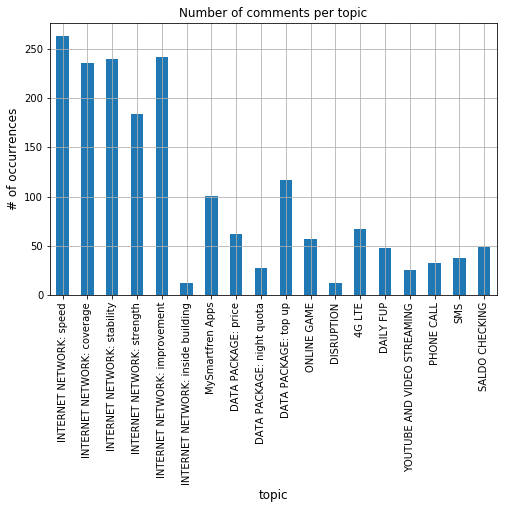

In [60]:
df_stats.plot(x='topic', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per topic")
plt.ylabel('# of occurrences', fontsize=12)
plt.xlabel('topic', fontsize=12)

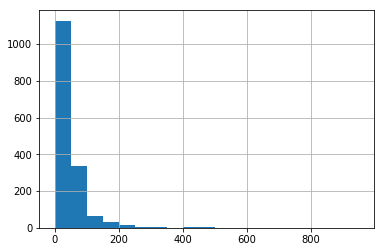

In [61]:

lens = data_df.TEXT_SPELL_CORRECTED.str.len()
lens.hist(bins = np.arange(0,1000,50))

In [0]:
def get_topics(row):
  t_list = []
  for col in df.columns:
    if row[col]==1:
      t_list.append(col)
  return t_list

In [0]:
data_df['topic_list'] = df.apply(get_topics, axis=1)

In [25]:
data_df.iloc[1020]

INTERNET NETWORK: speed                                           0
INTERNET NETWORK: coverage                                        0
INTERNET NETWORK: stability                                       0
INTERNET NETWORK: strength                                        0
INTERNET NETWORK: improvement                                     0
INTERNET NETWORK: inside building                                 0
MySmartfren Apps                                                  0
DATA PACKAGE: price                                               0
DATA PACKAGE: night quota                                         0
DATA PACKAGE: top up                                              0
ONLINE GAME                                                       0
DISRUPTION                                                        0
4G LTE                                                            0
DAILY FUP                                                         0
YOUTUBE AND VIDEO STREAMING                     

In [26]:
print(data_df['topic_list'].sample())

197    [INTERNET NETWORK: speed, INTERNET NETWORK: co...
Name: topic_list, dtype: object


In [0]:
from sklearn.datasets import make_multilabel_classification

# this will generate a random multi-label dataset
X, y = make_multilabel_classification(sparse = True, n_labels = 20,
return_indicator = 'sparse', allow_unlabeled = False)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data_df.TEXT_SPELL_CORRECTED.tolist())
# X = np.matrix(data_df.TEXT_SPELL_CORRECTED)
y = np.matrix(data_df.loc[:, data_df.columns != 'TEXT_SPELL_CORRECTED'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=6, test_size=0.4, shuffle=True)

In [89]:
X_train

<953x1845 sparse matrix of type '<class 'numpy.float64'>'
	with 6295 stored elements in Compressed Sparse Row format>

In [31]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 3.5MB/s 


In [90]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB

# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier = ClassifierChain(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

accuracy_score(y_test,predictions)

0.08490566037735849

In [91]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier = LabelPowerset(GaussianNB())

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

accuracy_score(y_test,predictions)

0.19339622641509435

In [92]:
from skmultilearn.adapt import MLkNN

classifier = MLkNN(k=20)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

accuracy_score(y_test,predictions)

0.6163522012578616

In [98]:
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__n_estimators': [10, 20, 50],
    },
]

clf = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy')
clf.fit(X_train, y_train)

print (clf.best_params_, clf.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'classifier__criterion': 'gini', 'classifier__n_estimators': 50} 0.5802728226652676


In [99]:
predictions = clf.predict(X_test)

accuracy_score(y_test,predictions)

0.6320754716981132

In [101]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.7, 1.0],
    },
    {
        'classifier': [SVC()],
        'classifier__kernel': ['rbf', 'linear'],
    },
]

clf = GridSearchCV(ClassifierChain(), parameters, scoring='accuracy')
clf.fit(X_train, y_train)

print (clf.best_params_, clf.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in v

{'classifier': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'classifier__kernel': 'linear'} 0.6768100734522561


In [102]:
predictions = clf.predict(X_test)

accuracy_score(y_test,predictions)

0.7358490566037735

In [106]:
print(X_train[0])

  (0, 128)	0.5387256603494792
  (0, 923)	0.3715122142971496
  (0, 1696)	0.5067192725609214
  (0, 76)	0.5067192725609214
  (0, 379)	0.24129752410604502


In [96]:
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD

classifier = RakelD(
    base_classifier=GaussianNB(),
    base_classifier_require_dense=[True, True],
    labelset_size=4
)

classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)
accuracy_score(y_test,prediction)

0.0959119496855346

In [0]:
topics = list(df_stats['topic'].values)

In [0]:
# Define a pipeline combining a text feature extractor with multi label classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [0]:
for topic in topics:
    print('... Processing {}'.format(topic))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[topic])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[topic], prediction)))
    

... Processing INTERNET NETWORK: speed
Test accuracy is 0.8522012578616353
... Processing INTERNET NETWORK: coverage
Test accuracy is 0.8930817610062893
... Processing INTERNET NETWORK: stability
Test accuracy is 0.8663522012578616
... Processing INTERNET NETWORK: strength
Test accuracy is 0.8962264150943396
... Processing INTERNET NETWORK: improvement
Test accuracy is 0.8883647798742138
... Processing INTERNET NETWORK: inside building
Test accuracy is 0.9937106918238994
... Processing MySmartfren Apps
Test accuracy is 0.9591194968553459
... Processing DATA PACKAGE: price
Test accuracy is 0.9559748427672956
... Processing DATA PACKAGE: night quota
Test accuracy is 0.9827044025157232
... Processing DATA PACKAGE: top up
Test accuracy is 0.9323899371069182
... Processing ONLINE GAME
Test accuracy is 0.9638364779874213
... Processing DISRUPTION
Test accuracy is 0.9889937106918238
... Processing 4G LTE
Test accuracy is 0.9622641509433962
... Processing DAILY FUP
Test accuracy is 0.970125786

In [0]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

In [0]:
for topic in topics:
    print('... Processing {}'.format(topic))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[topic])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[topic], prediction)))

... Processing INTERNET NETWORK: speed
Test accuracy is 0.960691823899371
... Processing INTERNET NETWORK: coverage
Test accuracy is 0.9779874213836478
... Processing INTERNET NETWORK: stability
Test accuracy is 0.960691823899371
... Processing INTERNET NETWORK: strength
Test accuracy is 0.9638364779874213
... Processing INTERNET NETWORK: improvement
Test accuracy is 0.9654088050314465
... Processing INTERNET NETWORK: inside building
Test accuracy is 0.9937106918238994
... Processing MySmartfren Apps
Test accuracy is 0.9905660377358491
... Processing DATA PACKAGE: price
Test accuracy is 0.9795597484276729
... Processing DATA PACKAGE: night quota
Test accuracy is 0.9921383647798742
... Processing DATA PACKAGE: top up
Test accuracy is 0.9748427672955975
... Processing ONLINE GAME
Test accuracy is 0.9984276729559748
... Processing DISRUPTION
Test accuracy is 0.9921383647798742
... Processing 4G LTE
Test accuracy is 0.9937106918238994
... Processing DAILY FUP
Test accuracy is 0.98427672955

In [0]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear'))),
            ])

In [0]:
for topic in topics:
    print('... Processing {}'.format(topic))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[topic])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[topic], prediction)))

... Processing INTERNET NETWORK: speed
Test accuracy is 0.910377358490566
... Processing INTERNET NETWORK: coverage
Test accuracy is 0.9198113207547169
... Processing INTERNET NETWORK: stability
Test accuracy is 0.9088050314465409
... Processing INTERNET NETWORK: strength
Test accuracy is 0.9245283018867925
... Processing INTERNET NETWORK: improvement
Test accuracy is 0.9166666666666666
... Processing INTERNET NETWORK: inside building
Test accuracy is 0.9937106918238994
... Processing MySmartfren Apps
Test accuracy is 0.970125786163522
... Processing DATA PACKAGE: price
Test accuracy is 0.960691823899371
... Processing DATA PACKAGE: night quota
Test accuracy is 0.9827044025157232
... Processing DATA PACKAGE: top up
Test accuracy is 0.9449685534591195
... Processing ONLINE GAME
Test accuracy is 0.970125786163522
... Processing DISRUPTION
Test accuracy is 0.9889937106918238
... Processing 4G LTE
Test accuracy is 0.9764150943396226
... Processing DAILY FUP
Test accuracy is 0.9701257861635

In [0]:
LogReg_pipeline

In [0]:
LogReg_pipeline.predict(pd.Series('Kestabilan sinyal, karena pada jam tertentu terutama jam 12 sampai 16 kecepatan data turun. Hal ini juga terjadi di jam 17 sampai 22 malam, kecepatan juga turun drastis. Hal ini dibuktikan pd saat streaming Youtube di 360, itu buffering'))

array([0])

In [0]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.inverse_transform(prediction)[3]

NotFittedError: ignored